# Gereksinimlerin Kurulması

In [1]:
!git clone https://github.com/ultralytics/yolov5 #git reposunu colaba çekiyoruz.
!rm -r samle_data

Cloning into 'yolov5'...
remote: Enumerating objects: 12251, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 12251 (delta 10), reused 14 (delta 8), pack-reused 12229
Receiving objects: 100% (12251/12251), 11.94 MiB | 31.12 MiB/s, done.
Resolving deltas: 100% (8480/8480), done.
rm: cannot remove 'samle_data': No such file or directory


In [2]:
%cd /content/yolov5
!pip install -r requirements.txt

/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 7.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

#Veri Seti Çekme, .xml den .txt ' ye çevirme vs.

In [4]:
import gdown
url = "https://drive.google.com/uc?id=1krgjnaSxn5GI1h7RKRnvJK1HALHxcUVq"
out_path =  "verisetison.zip"
gdown.download(url, out_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1krgjnaSxn5GI1h7RKRnvJK1HALHxcUVq
To: /content/yolov5/verisetison.zip
100%|██████████| 305M/305M [00:04<00:00, 68.2MB/s]


'verisetison.zip'

In [5]:
%cd /content/yolov5
!mkdir annotations
!unzip -q /content/yolov5/verisetison.zip
!mv /content/yolov5/content/Datasets/*.jpg /content/yolov5/annotations
!mv /content/yolov5/content/Datasets/*.xml /content/yolov5/annotations
!rm -r /content/yolov5/content
!rm -r verisetison.zip

/content/yolov5


In [6]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [7]:
extract_info_from_xml("/content/yolov5/annotations/W1.xml")

{'bboxes': [{'class': '2', 'xmax': 272, 'xmin': 238, 'ymax': 240, 'ymin': 186},
  {'class': '1', 'xmax': 347, 'xmin': 306, 'ymax': 254, 'ymin': 128}],
 'filename': 'W1.jpg',
 'image_size': (720, 576, 3)}

## Nesne Sınıfı İD Değerlerinin Haritalanması

In [8]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"0" : 0,
                            "1" : 1,
                            "2" : 2,
                            "3" : 3,
                            }
#class                     

# Convert the info dict to the required yolo format and write it to diskuai
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

## Xml'den Txt'ye Çevirme

In [9]:
###XML2TXT
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 1411/1411 [00:00<00:00, 2459.65it/s]


In [10]:
!rm -r /content/yolov5/annotations/*.xml

In [11]:
!mkdir images #dosyayı yeniden taşımam gerekti

In [12]:
!mv /content/yolov5/annotations/*.jpg /content/yolov5/images

## Örnek Verinin Görüntülenmesi

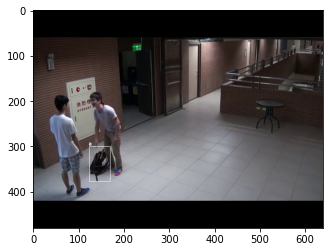

In [13]:
random.seed(125)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

## VeriSetinin Random Olarak Üç Kümeye Ayırma

In [14]:
#SPLİT Section - @v01dString
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"] 
images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.1, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [15]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [16]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

#Eğitimin Başlatılması ve Config Dosyasının Çekilmesi

In [17]:
#config dosyasının indirilmesi
import gdown
url = "https://drive.google.com/uc?id=15DRv0TolyEmEX9R_3tV-0K_I_ikl_WLE"
out_path =  "config.yaml"
gdown.download(url, out_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=15DRv0TolyEmEX9R_3tV-0K_I_ikl_WLE
To: /content/yolov5/config.yaml
100%|██████████| 169/169 [00:00<00:00, 86.9kB/s]


'config.yaml'

In [18]:
!mv /content/yolov5/config.yaml /content/yolov5/data

In [19]:
os.rename("/content/yolov5/annotations","/content/yolov5/labels")

In [21]:
!python train.py --img 480 --cfg yolov5x.yaml --hyp hyp.VOC.yaml --batch 1 --epochs 30 --data config.yaml --weights yolov5x.pt --workers 24 --name Sonuc

train: weights=yolov5x.pt, cfg=yolov5x.yaml, data=config.yaml, hyp=hyp.VOC.yaml, epochs=30, batch_size=1, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=Sonuc, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-252-g6a67594 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.00334, lrf=0.15135, momentum=0.74832, weight_decay=0.00025, warmup_epochs=3.3835, warmup_momentum=0.59462, warmup_bias_lr=0.18657, box=0.02, cls=0.21638, cls_pw=0.5, obj=0.51728, obj_pw=0.67198, iou_t=0.2, anchor_t=3.3744, fl_gamma=0.0, 

#Modeli Zipleyip Drivea Çekme [Opsiyonel]

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


%cd /content/yolov5/runs/train/Sonuc2
!zip -r İkinciEgitim.zip /content/yolov5/runs/train/Sonuc2

In [29]:
!cp /content/yolov5/runs/train/Sonuc2/İkinciEgitim.zip /content/drive/MyDrive/DönemProjesi

In [31]:
!cp /content/yolov5/runs/train/Sonuc2/weights/best2.pt /content/drive/MyDrive/DönemProjesi